In [1]:
'''
Program to perform 3D element analysis
Unit: mm
Author: Yitian Shao
Created on 2021.06.02
'''
# Repeat IPython function to prevent some graphical glitches
%matplotlib notebook 
%matplotlib notebook 

import sys
import time
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
'''
Enable fast computing using c shared library and parallel programming
'''
enableFastComputing = True;

if(enableFastComputing):
    try:
        import ctypes    
        from ctypes import util
        from ctypes import CDLL
    except:
        print("ctypes unfounded, switch to normal python computing")
        enableFastComputing = False;

    if(enableFastComputing):
        try:
            libPath = ctypes.util.find_library("c/triangle_integral")
            triangle_integral = ctypes.CDLL(libPath)

            triangle_integral.computeVol.argtypes = [ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, 
                                                ctypes.c_double, ctypes.c_double]
            triangle_integral.computeVol.restype = ctypes.c_double
            
            triangle_integral.computeTriTEFE.argtypes = [ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, 
                                    ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double]
            triangle_integral.computeTriTEFE.restype = ctypes.c_double
            
            triangle_integral.computeRectTEFE.argtypes = [ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, 
                                    ctypes.c_double, ctypes.c_double, ctypes.c_double]
            triangle_integral.computeRectTEFE.restype = ctypes.c_double
            
            print("c shared library imported successfully!")
        except:
            print("c shared library unfounded, switch to normal python computing")
            enableFastComputing = False;


c shared library imported successfully!


In [3]:
'''
Simulation parameters 
'''
R = 50 # (mm) Radius of the sphere
c = 46#30 # (mm) Offset distance of the front cut from the center of the sphere
m = 40#17.32 # (mm) half-length of the open area of the pouch, m < r. (34.641 = sqrt(3) * 20)

w = 40 # (mm) Width of the rectangle pouch

dispAllPouch = False # Display all pouch ( True / False )

dispAd = True # Display all additive sketch for better illustration ( True / False )

# For the trangle
meshDensity = int(2 * R) # density of vertices of the mesh, large value results in finer grid but larger memory demand
adPlotDensity = int(2 * R) # density of additive plot of curves and circles

# For the rectangle
# density of vertices of the mesh, large value results in finer grid but larger memory demand
# meshDensity2 # Can be determined by triangle pouch
# density of additive plot of curves and circles
adPlotDensity2 = adPlotDensity #int(6 * w) 

intStepSize = 0.0001 # (mm) Step size for performing integral computation

if(dispAllPouch):
    # Display range for each axis: [xOffset, yOffset, zOffset, xScale, yScale, zScale]
    dispRange = [-w, -4 * m, -2*R, 7 * w, 8 * m, 4*R] 
else:
    dispRange = [0,  -R,       -R, 2 * R, 2 * R, 2 * R] 

'''Dielectric parameters'''  
epsilon_0 = 8.8541878128e-12 # Vacuum permittivity (Farad/m) or (N/V2)
epsilon_f = 2.0 # Relative permittivity of the dielectric fluid 
voltage = 10000 # Voltage applied to the dielectric (Volt)
filmThickness = 0.020 # (20 um) Thickness of the insulating film of the pouch


In [4]:
'''
General Functions
'''
def data_cut(x, y, z, ind):
    return x[ind], y[ind], z[ind]

def coordTrans2D(a, b, theta, a_translate, b_translate):
    # 2D coordinate transformation, rotate counter-clockwise by angle theta and then translate
    rotMat = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    ab = np.matmul(rotMat, np.stack((a, b)))
    ab[0,:] += a_translate
    ab[1,:] += b_translate
    return ab

def fitPlane2Points(p1, p2, p3):
    # Fit a plane to three nonalighed points
    return np.cross(p1 - p2, p3 - p2)

def computeCornerVolume(s, f, R, intStepSize):
    # Compute the volume of a corner of a sphere cutted by two perpendicular planes
    # 's' - radius of top cutting circle
    # 'f' - the distance between the center of front cutting circle to the center of the sphere
    # 'R' - radius of the sphere being cutted
    # 'intStepSize'- the resolution of the integral 
    a = np.arange(f**2, s**2, intStepSize)
    cornerArea = (f * np.sqrt(a - f**2) - a * np.arccos(f/np.sqrt(a))) / (2 * np.sqrt(R**2 - a))
    return -np.sum(intStepSize * cornerArea)

def computeCornerArea(r, rad):
    # 'r' - the radius of the cutting circle
    # 'rad' - radian angle of the cutting sector
    return (rad - np.sin(rad)*np.cos(rad)) * r**2

def computeElectricField(voltage, filmThickness, distArray):
    # Result in electric field (Unit: V/mm) NOTE: the unit is Volt per millimeter!
    distArray[distArray == 0] = filmThickness # Avoid dividing zero, by considering film thickness
    return np.reciprocal(distArray) * voltage

def computeMaxwellStress(epsilon_r, voltage, distArray):
    # Result in maxwell stress (Unit: N/m2)
    epsilon_0 = 8.8541878128 * 1e-12 # Vacuum permittivity (farads per meter)
    electricFieldArray = 1000 * computeElectricField(voltage, distArray) # Convert unit from V/mm to V/m
    return electricFieldArray**2 * epsilon_0 * epsilon_r * 0.5
    

In [5]:
'''
Class
'''
class TrianglePouch:
    # Triangle pouch is formed by cutting front, and symmetrically two sides, then top of a sphere 
    # 'R' - radius of the sphere being cutted
    # 'c' - heigh of the triangle
    # 'm' - half width of the triangle bottom
    #  --------------------------------------
    # 'f' - distance between the center of front cutting circle to the center of the sphere
    # 's' - radius of the top cutting circle
    # 'r' - radius of the front cutting circle
    # 'h' - distance between the center of top cutting circle to the center of the sphere
    # 'n' - half length of the triangle side
    # 'intStepSize' controls the resolution of the integral
    #  --------------------------------------
    # 'meshDensity' - density of vertices of the mesh of the pouch
    # 'adPlotDensity' - density of vertices of additive plot
    # 'addAd' - construct additive plot 
    # 'dispCurve' - Display curve or the full circle for additive plot
    #  --------------------------------------------------------------------------------------------------------------------
    def __init__(self, R = 50, c = 20, m = 34.641, meshDensity = 100, adPlotDensity = 100, addAd = False, dispCurve = True):
        self.R = R
        self.c = c
        self.m = m
        self.meshDensity = meshDensity
        self.adPlotDensity = adPlotDensity
        self.triangle = []
        self.frontCircle = []
        self.frontLine = []
        self.leftCircle = []
        self.leftLine = []
        self.rightCircle = []
        self.rightLine = []     
        
        if(self.c <= 0):
            print("Invalid value: c must be greater than 0!")
            
        self.beta = np.arctan(self.m/self.c) # Angle Beta (viewing from the top)
        
        self.f = 0.5 * (-self.m**2/self.c + self.c)
        self.s = 0.5 * (self.m**2/self.c + self.c)
        self.r = np.sqrt(self.R**2 - self.f**2) # Radius of the front cutting circle, r < R
        
        if(self.m > self.r):
            sys.exit("Invalid value: m cannot be greater than r!")
        elif(self.m == self.r):
            print("Warning: h equals 0!")
            
        if(self.f < 0 or self.f >= self.R):
            sys.exit("Invalid f!")
        if(self.r < self.m):
            sys.exit("Invalid r!")
            
        self.h = np.sqrt(self.r**2 - self.m**2) # (mm) Cutting height of the sphere, Pouch height will be 2(r-h)
        self.alpha = np.arccos(self.h/self.r) # Angle Alpha (viewing from the front) 
        
        self.n = self.s * np.cos(self.beta)
        self.rSide = np.sqrt(self.n**2 + self.h**2)
        
        # Triangle coordinates (can be updated)
        self.triangleTopX = self.R - self.s # Note: Triangle mirror point 1
        self.triangleBottomX = self.c + self.triangleTopX # Note: Triangle mirror point 2
        self.cCenterX = self.n * np.cos(self.beta) + self.triangleTopX
        self.cCenterY = -self.n * np.sin(self.beta)
        
        # Generate the mesh of the triangle pouch
        self.dx = 2*R/self.meshDensity
        self.dy = self.dx
        x = np.outer(np.linspace(0, 2*R, self.meshDensity+1), np.ones(self.meshDensity+1))
        y = np.outer(np.ones(self.meshDensity+1), np.linspace(-R, R, self.meshDensity+1))
        z2 = R**2 - (x-R)**2 - (y**2) # Supposed to be square of z when on the sphere, but can be negative

        # Keep sphere upper surface
        keepInd = (z2 >= 0)
        x, y, z2 = data_cut(x, y, z2, keepInd)
        z = np.sqrt(z2) # Square root of z2

        # Cut the sphere
        keepInd = (z >= self.h)
        x, y, z = data_cut(x, y, z, keepInd)

        # Cut the Front Face (surface crossing the pouch)
        keepInd = (x <= self.f + self.R)
        x, y, z = data_cut(x, y, z, keepInd)

        # Cut the left-side face
        pNormVector = fitPlane2Points(np.array([self.triangleTopX, 0, self.h]), 
                                      np.array([self.cCenterX, self.cCenterY, -self.rSide]), 
                                      np.array([self.triangleBottomX, -self.m, self.h]))
        keepInd = (np.matmul(pNormVector, np.stack((x - self.cCenterX, y - self.cCenterY, z))) >= 0)
        x, y, z = data_cut(x, y, z, keepInd)

        # Cut the right-side face
        pNormVector2 = fitPlane2Points(np.array([self.triangleTopX, 0, self.h]), 
                                       np.array([self.cCenterX, -self.cCenterY, -self.rSide]), 
                                      np.array([self.triangleBottomX, self.m, self.h]))
        keepInd = (np.matmul(pNormVector2, np.stack((x - self.cCenterX, y + self.cCenterY, z))) <= 0)
        x, y, z = data_cut(x, y, z, keepInd)
        
        self.triangle = np.stack((x, y, z - self.h)) # Vertex coordinate of the triangle pouch
        if(self.triangle.size == 0):
            sys.exit("Warning: Insufficient mesh density!")
               
        if(addAd):
            self.__additiveLine(dispCurve)
 
        ###print("Estimate Tri V = %.3f (mm3)" % np.sum(self.triangle[2,:] * self.dx * self.dy)) # Debug 
        
    def printInfo(self):
        print("(Unzeroed coordinate) c = %.2f mm, m = %.2f mm, r = %.2f mm, h = %.2f mm, s = %.2f mm, n = %.2f mm, rSide = %.2f mm" % 
              (self.c, self.m, self.r, self.h, self.s, self.n, self.rSide))
        print("Spatial resolution dx = %f mm, dy = %f mm" % (self.dx, self.dy))
        print("Angle: Alpha = %.1f degree, Beta = %.1f degree" % (180*self.alpha/np.pi, 180*self.beta/np.pi))
        print("triangle with top at (%.2f, %.2f, %.2f) and left bottom at (%.2f, %.2f, %.2f)" % 
              (self.triangleTopX, 0, 0, self.triangleBottomX, -self.m, 0))

    # Private function for adding additive sketch for clear illustration
    def __additiveLine(self, dispCurve = True):
        # 'dispCurve' decides whether to display a curve or the entire circle
        
        # Front circle and line
        fAngle = np.linspace(0, 2*np.pi, self.adPlotDensity)
        x = (self.R + self.f) * np.ones(self.adPlotDensity)
        y = self.r * np.cos(fAngle)
        z = self.r * np.sin(fAngle)
        self.frontCircle = np.stack((x, y, z - self.h)) # Vertex coordinate of the front circle (Zero offset)
        if(dispCurve):
            keepInd = (z >= self.h)
            self.frontCircle = self.frontCircle[:, keepInd]
        
        self.frontLine = np.array([[self.R + self.f, self.R + self.f], [-self.m, self.m],
                                   [0.0, 0.0]]) # Coordinate of the front line
        
        # Side circle and line
        x, y = coordTrans2D(self.rSide * np.cos(fAngle), np.zeros(self.adPlotDensity), -self.beta, 
                            self.cCenterX, self.cCenterY)
        z = self.rSide * np.sin(fAngle)
        self.leftCircle = np.stack((x, y, z - self.h)) # Vertex coordinate of the left-side circle (Zero offset)
        if(dispCurve):
            keepInd = (z >= self.h)
            self.leftCircle = self.leftCircle[:, keepInd]
            
        self.leftLine = np.array([[self.triangleTopX, self.triangleBottomX], [0, -self.m], [0.0, 0.0]])
        ###leftRadiusLine = np.array([[triangleTopX, cCenterX], [0, cCenterY], [h, 0]])# For reference only

        x, y = coordTrans2D(self.rSide * np.cos(fAngle), np.zeros(self.adPlotDensity), self.beta, 
                            self.cCenterX, -self.cCenterY)
        self.rightCircle = np.stack((x, y, z - self.h)) # Vertex coordinate of the right-side circle (Zero offset)
        if(dispCurve):
            keepInd = (z >= self.h)
            self.rightCircle = self.rightCircle[:, keepInd]
            
        self.rightLine = np.array([[self.triangleTopX, self.triangleBottomX], [0, self.m], [0.0, 0.0]])
    
    # Private function for updating the coordinate of the mesh and lines
    def __updateCoordinate(self, movedx = 0, movedy = 0, movedz = 0):
        self.triangle[0,:] += movedx
        self.triangle[1,:] += movedy
        self.triangle[2,:] += movedz
        
        if(len(self.frontCircle)):
            self.frontCircle[0,:] += movedx
            self.frontCircle[1,:] += movedy
            self.frontCircle[2,:] += movedz

        if(len(self.frontLine)):
            self.frontLine[0,:] += movedx
            self.frontLine[1,:] += movedy
            self.frontLine[2,:] += movedz

        if(len(self.leftCircle)):
            self.leftCircle[0,:] += movedx
            self.leftCircle[1,:] += movedy
            self.leftCircle[2,:] += movedz

        if(len(self.leftLine)):
            self.leftLine[0,:] += movedx
            self.leftLine[1,:] += movedy
            self.leftLine[2,:] += movedz

        if(len(self.rightCircle)):
            self.rightCircle[0,:] += movedx
            self.rightCircle[1,:] += movedy
            self.rightCircle[2,:] += movedz

        if(len(self.rightLine)):
            self.rightLine[0,:] += movedx
            self.rightLine[1,:] += movedy
            self.rightLine[2,:] += movedz
        
        self.triangleTopX += movedx
        self.triangleBottomX += movedx
        self.cCenterX += movedx
        self.cCenterY += movedy
           
    def transformPouch(self, x = 0, y = 0, z = 0, flip = False):
        # Flip along the x axis
        if(flip):
            self.triangle[0,:] *= -1
            
            if(len(self.frontCircle)):
                self.frontCircle[0,:] *= -1
                
            if(len(self.frontLine)):
                self.frontLine[0,:] *= -1
                
            if(len(self.leftCircle)):
                self.leftCircle[0,:] *= -1
                
            if(len(self.leftLine)):
                self.leftLine[0,:] *= -1
                
            if(len(self.rightCircle)):
                self.rightCircle[0,:] *= -1
                
            if(len(self.rightLine)):
                self.rightLine[0,:] *= -1
                
            self.triangleTopX *= -1
            self.triangleBottomX *= -1
            self.cCenterX *= -1
            self.cCenterX *= -1
            
            # After flip, shift to align the current top to: the bottom before flipping
            self.__updateCoordinate(-self.triangleTopX -self.triangleBottomX, -self.m, 0)        
        
        # Translation
        self.__updateCoordinate(x, y, z)
        
                
    def displayPouch(self, ax, dispAdditive = False):
        ax.scatter3D(self.triangle[0,:], self.triangle[1,:], self.triangle[2,:], 
                 s = 1, edgecolor="k", facecolor=(0,0,0,0))
        
        if(dispAdditive):
            # Additive plot
            # Plot front circle
            if(len(self.frontCircle)):
                ax.plot(self.frontCircle[0,:], self.frontCircle[1,:], self.frontCircle[2,:], '--', c = 'g')
                
            # Plot front line
            if(len(self.frontLine)):
                ax.plot(self.frontLine[0,:], self.frontLine[1,:], self.frontLine[2,:], c = 'g')
                
            # Plot left circle
            if(len(self.leftCircle)):
                ax.plot(self.leftCircle[0,:], self.leftCircle[1,:], self.leftCircle[2,:], '--', c = 'b')
                
            # Plot left line
            if(len(self.leftLine)):
                ax.plot(self.leftLine[0,:], self.leftLine[1,:], self.leftLine[2,:], c = 'b')
                
            # Plot right circle
            if(len(self.rightCircle)):
                ax.plot(self.rightCircle[0,:], self.rightCircle[1,:], self.rightCircle[2,:], '--', c = 'b')
                
            # Plot right line
            if(len(self.rightLine)):
                ax.plot(self.rightLine[0,:], self.rightLine[1,:], self.rightLine[2,:], c = 'b')
 
    def getVolume(self, intStepSize):   
        if(enableFastComputing):
            return triangle_integral.computeVol(self.s, self.f, self.R, self.h, self.n, intStepSize)
        
        # Normal computing when fast computing is unavailable 
        frontCornerVol = computeCornerVolume(self.s, self.f, self.R, intStepSize)

        sideCornerVol = computeCornerVolume(self.s, np.sqrt(self.s**2 - self.n**2), self.R, intStepSize)

        domeVol = ( 2 * self.R**2 * (self.R - self.h) + self.h * (self.h**2 - self.R**2) ) * np.pi/3
    
        return domeVol - frontCornerVol - 2*sideCornerVol
    
    def getFrontArea(self):
        return computeCornerArea(self.r, self.alpha)
    
    def getProjectedSideArea(self):
        # Area of two side-cutting circle projected onto the front-cutting circle
        sideArea = computeCornerArea(self.rSide, np.arcsin(self.n/self.rSide))
        return sideArea * np.sin(self.beta) * 2
    
    def getTotalForce(self, epsilon_r, voltage, zThick, epsilon_0 = 8.854e-12, intStepSize = 0.001):
        if(not enableFastComputing):
            sys.exit("Unable to compute Force without Fast Computing!")
            
        return triangle_integral.computeTriTEFE(-self.s, self.f, 0.0, self.h - zThick, self.R, self.m, 
                                                    voltage, intStepSize) * 0.5 * epsilon_0 * epsilon_r


    
'''----------------------------------------------------------------------------------------------------------------------'''
'''----------------------------------------------------------------------------------------------------------------------'''

class RectanglePouch:
    def __init__(self, r = 10, w = 50, m = 0, meshDensity = 100, adPlotDensity = 100, addAd = False, dispCurve = True):
        self.r = r
        self.w = w
        self.m = m
        self.meshDensity = meshDensity
        self.adPlotDensity = adPlotDensity
        self.frontLine = []
        self.leftLine = []
        self.rightLine = []
        
        if(self.m > self.r):
            sys.exit("Invalid value: m must be smaller than r")
        
        self.alpha = np.arcsin(self.m/self.r) # Angle Alpha (viewing from the front) 
        self.zCut = np.sqrt(self.r**2 - self.m**2) # Supposed to be the h of the triangle pouch
    
        # Generate the mesh of the rectangle pouch
        self.dy = 2*self.m/self.meshDensity
        self.dx = self.dy
        xRows = np.arange(0.0, self.w, self.dy)
        yCols = np.arange(-r + 0.000001, r - 0.000001, self.dy)    
               
        x = np.outer(xRows, np.ones(yCols.size))
        y = np.outer(np.ones(xRows.size), yCols)
        z = np.sqrt(self.r**2 - y**2)
        
        keepInd = (z >= self.zCut)
        x, y, z = data_cut(x, y, z, keepInd)
        self.rectangle = np.stack((x, y, z - self.zCut))
        if(self.rectangle.size == 0):
            sys.exit("Warning: Insufficient mesh density!")

        if(addAd):
            self.__additiveLine(dispCurve)
            
        ###print("Estimate Rect V = %.3f (mm3)" % np.sum(self.rectangle[2,:] * self.dx * self.dy)) # Debug 
    
    # Private function for adding additive sketch for clear illustration
    def __additiveLine(self, dispCurve = True):
        # 'dispCurve' decides whether to display a curve or the entire circle
        fAngle = np.linspace(0, 2*np.pi, self.adPlotDensity)
        x = self.w * np.ones(self.adPlotDensity)
        y = self.r * np.cos(fAngle)
        z = self.r * np.sin(fAngle)
        self.frontCircle = np.stack((x, y, z - self.zCut)) # Vertex coordinate of the front circle (Zero offset) 
        
        if(dispCurve):
            keepInd = (z >= self.zCut)
            self.frontCircle = self.frontCircle[:, keepInd]
        
        # Coordinate of the front line
        self.frontLine = np.array([[self.w, self.w], [-self.m, self.m], [0.0, 0.0]]) 
        # Coordinate of the left line
        self.leftLine = np.array([[0, self.w], [-self.m, -self.m], [0.0, 0.0]]) 
        # Coordinate of the right line
        self.rightLine = np.array([[0, self.w], [self.m, self.m], [0.0, 0.0]]) 
        
    
    def transformPouch(self, movedx = 0, movedy = 0, movedz = 0):
        self.rectangle[0,:] += movedx
        self.rectangle[1,:] += movedy
        self.rectangle[2,:] += movedz
        
        if(len(self.frontCircle)):
            self.frontCircle[0,:] += movedx
            self.frontCircle[1,:] += movedy
            self.frontCircle[2,:] += movedz

        if(len(self.frontLine)):
            self.frontLine[0,:] += movedx
            self.frontLine[1,:] += movedy
            self.frontLine[2,:] += movedz

        if(len(self.leftLine)):
            self.leftLine[0,:] += movedx
            self.leftLine[1,:] += movedy
            self.leftLine[2,:] += movedz

        if(len(self.rightLine)):
            self.rightLine[0,:] += movedx
            self.rightLine[1,:] += movedy
            self.rightLine[2,:] += movedz
            
    def displayPouch(self, ax, dispAdditive = False):
        ax.scatter3D(self.rectangle[0,:], self.rectangle[1,:], self.rectangle[2,:], 
                         s = 1, edgecolor="k", facecolor=(0,0,0,0))
        
        if(dispAdditive):
            # Additive plot
            # Plot front circle
            if(len(self.frontCircle)):
                ax.plot(self.frontCircle[0,:], self.frontCircle[1,:], self.frontCircle[2,:], '--', c = 'g')
                
            # Plot front line
            if(len(self.frontLine)):
                ax.plot(self.frontLine[0,:], self.frontLine[1,:], self.frontLine[2,:], c = 'g')
                
            # Plot left line
            if(len(self.leftLine)):
                ax.plot(self.leftLine[0,:], self.leftLine[1,:], self.leftLine[2,:], c = 'r')
                
            # Plot right line
            if(len(self.rightLine)):
                ax.plot(self.rightLine[0,:], self.rightLine[1,:], self.rightLine[2,:], c = 'r')
    
    def getVolume(self): 
        return (self.alpha * self.r**2 - self.zCut * self.m) * self.w
    
    def getTotalForce(self, epsilon_r, voltage, zThick, epsilon_0 = 8.854e-12, intStepSize = 0.001):
        if(not enableFastComputing):
            sys.exit("Unable to compute Force without Fast Computing!")
            
        return triangle_integral.computeRectTEFE(0.0, self.m, self.zCut - zThick, self.r, self.w,
                                                    voltage, intStepSize) * 0.5 * epsilon_0 * epsilon_r    


<IPython.core.display.Javascript object>


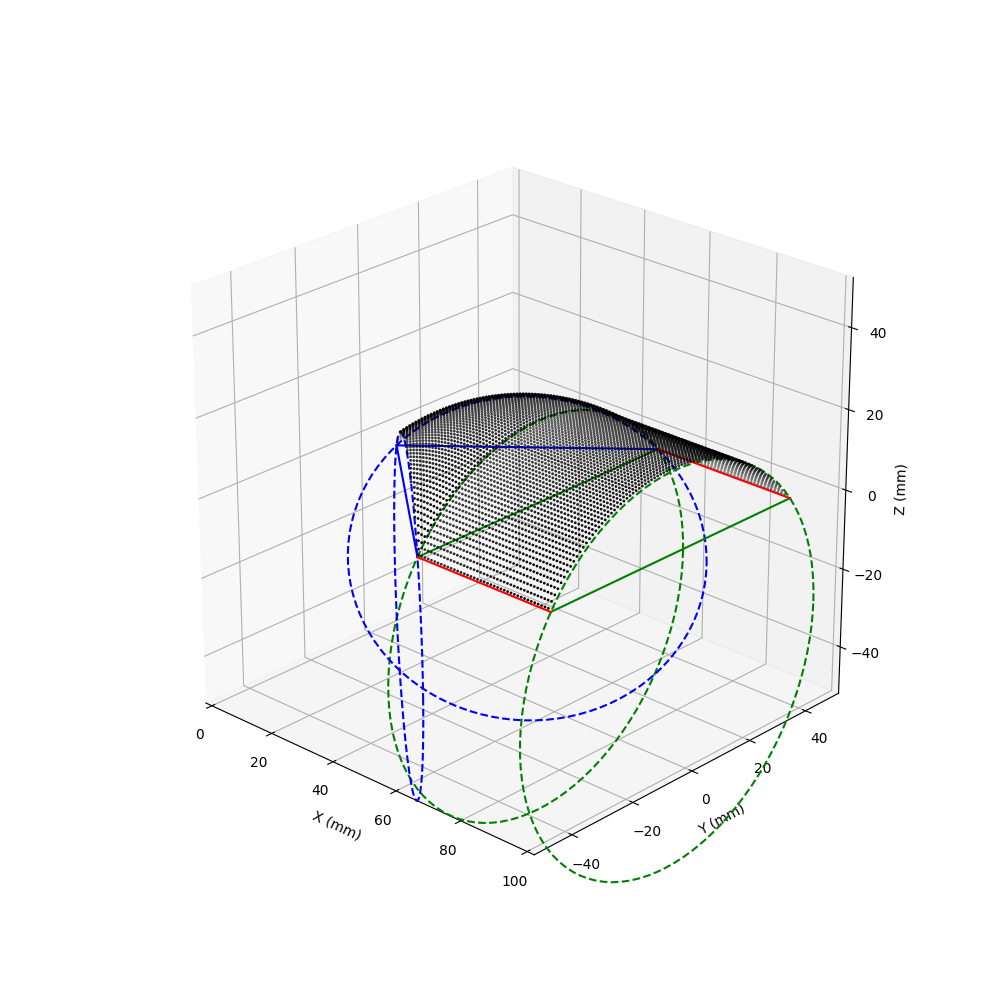

(Unzeroed coordinate) c = 46.00 mm, m = 40.00 mm, r = 49.68 mm, h = 29.47 mm, s = 40.39 mm, n = 30.48 mm, rSide = 42.40 mm
Spatial resolution dx = 1.000000 mm, dy = 1.000000 mm
Angle: Alpha = 53.6 degree, Beta = 41.0 degree
triangle with top at (9.61, 0.00, 0.00) and left bottom at (55.61, -40.00, 0.00)


In [10]:
'''
Visualization
'''
fig1 = plt.figure(figsize = (10,10)) # Initialize a figure
ax = fig1.add_subplot(111, projection='3d')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_xlim3d([dispRange[0], dispRange[0] + dispRange[3]])
ax.set_ylim3d([dispRange[1], dispRange[1] + dispRange[4]])
ax.set_zlim3d([dispRange[2], dispRange[2] + dispRange[5]])
ax.set_box_aspect([dispRange[3], dispRange[4], dispRange[5]])
plt.show()

if(dispAllPouch):
    # Generate Triange Pouch: Row 1
    triPouch0 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd, dispCurve = True)
    triPouch0.displayPouch(ax, dispAdditive = True) # Plot the triangle pouch
    triPouch0.printInfo()
    triPouch1 = TrianglePouch(R, c, m, meshDensity)
    triPouch1.transformPouch(0, 0, 0, flip = True) # Flip odd number triangle
    triPouch1.displayPouch(ax)                      # Plot the triangle pouch

#     triPouch2 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd)
#     triPouch2.transformPouch(0, -2 * m, 0)
#     triPouch2.displayPouch(ax, dispAdditive = True) # Plot the triangle pouch
#     triPouch3 = TrianglePouch(R, c, m, meshDensity)
#     triPouch3.transformPouch(0, -2 * m, 0, flip = True) # Flip odd number triangle
#     triPouch3.displayPouch(ax)                      # Plot the triangle pouch

#     triPouch4 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd)
#     triPouch4.transformPouch(0, 2 * m, 0)
#     triPouch4.displayPouch(ax, dispAdditive = True) # Plot the triangle pouch
    triPouch5 = TrianglePouch(R, c, m, meshDensity)
    triPouch5.transformPouch(0, 2 * m, 0, flip = True) # Flip odd number triangle
    triPouch5.displayPouch(ax)                      # Plot the triangle pouch

#     triPouch7 = TrianglePouch(R, c, m, meshDensity)
#     triPouch7.transformPouch(0, 4 * m, 0, flip = True) # Flip odd number triangle
#     triPouch7.displayPouch(ax)                      # Plot the triangle pouch

    meshDensity2 = 2*triPouch0.m/triPouch0.dy

    # Generate Rectangle Pouch: Row 2
    rectPouch0 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
    rectPouch0.transformPouch(triPouch0.triangleBottomX, 0, 0)
    rectPouch0.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

#     rectPouch1 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
#     rectPouch1.transformPouch(triPouch0.triangleBottomX, -2 * m, 0)
#     rectPouch1.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

#     rectPouch2 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
#     rectPouch2.transformPouch(triPouch0.triangleBottomX, 2 * m, 0)
#     rectPouch2.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

    # Generate Rectangle Pouch: Row 0
    rectPouch3 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
    rectPouch3.transformPouch(triPouch0.triangleTopX - w, -m, 0)
    rectPouch3.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

#     rectPouch4 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
#     rectPouch4.transformPouch(triPouch0.triangleTopX - w, -3 * m, 0)
#     rectPouch4.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

    rectPouch5 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
    rectPouch5.transformPouch(triPouch0.triangleTopX - w, m, 0)
    rectPouch5.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

#     rectPouch6 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
#     rectPouch6.transformPouch(triPouch0.triangleTopX - w, 3 * triPouch0.m, 0)
#     rectPouch6.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

#     # Generate Triange Pouch: Row 3
#     triPouch8 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd)
#     triPouch8.transformPouch(triPouch0.c + w, m, 0)
#     triPouch8.displayPouch(ax, dispAdditive = True) # Plot the triangle pouch
#     triPouch9 = TrianglePouch(R, c, m, meshDensity)
#     triPouch9.transformPouch(triPouch0.c + w, m, 0, flip = True) # Flip odd number triangle
#     triPouch9.displayPouch(ax)                      # Plot the triangle pouch

#     triPouch10 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd)
#     triPouch10.transformPouch(triPouch0.c + w, -m, 0)
#     triPouch10.displayPouch(ax, dispAdditive = True) # Plot the triangle pouch
#     triPouch11 = TrianglePouch(R, c, m, meshDensity)
#     triPouch11.transformPouch(triPouch0.c + w, -m, 0, flip = True) # Flip odd number triangle
#     triPouch11.displayPouch(ax)                      # Plot the triangle pouch

#     triPouch13 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd)
#     triPouch13.transformPouch(triPouch0.c + w, 3 * m, 0, flip = True)
#     triPouch13.displayPouch(ax) # Plot the triangle pouch

#     # Generate Rectangle Pouch: Row 4
#     rectPouch7 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
#     rectPouch7.transformPouch(triPouch0.triangleBottomX + triPouch0.c + w, -m, 0)
#     rectPouch7.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

#     rectPouch8 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
#     rectPouch8.transformPouch(triPouch0.triangleBottomX + triPouch0.c + w, m, 0)
#     rectPouch8.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

#     # Generate Triange Pouch: Row 5
#     triPouch14 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd)
#     triPouch14.transformPouch(2 * (triPouch0.c + w), 0, 0)
#     triPouch14.displayPouch(ax, dispAdditive = True) # Plot the triangle pouch
#     triPouch15 = TrianglePouch(R, c, m, meshDensity)
#     triPouch15.transformPouch(2 * (triPouch0.c + w), 0, 0, flip = True) # Flip odd number triangle
#     triPouch15.displayPouch(ax)                      # Plot the triangle pouch

#     triPouch17 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd)
#     triPouch17.transformPouch(2 * (triPouch0.c + w), 2 * m, 0, flip = True)
#     triPouch17.displayPouch(ax) # Plot the triangle pouch

#     # Generate Rectangle Pouch: Row 6
#     rectPouch9 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
#     rectPouch9.transformPouch(triPouch0.triangleBottomX + 2 * (triPouch0.c + w), 0, 0)
#     rectPouch9.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch
else:
    '''Display only one triangle and one rectangle pouch'''
    triPouch0 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd, dispCurve = False)
    triPouch0.displayPouch(ax, dispAdditive = True) 
    triPouch0.printInfo()
    
    meshDensity2 = 2*triPouch0.m/triPouch0.dy
    
    rectPouch0 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, 
                                addAd = dispAd, dispCurve = False)
    rectPouch0.transformPouch(triPouch0.triangleBottomX, 0, 0)
    rectPouch0.displayPouch(ax, dispAdditive = dispAd) 

ax.set_xlim3d([0, 100]); ax.set_ylim3d([-50, 50]); ax.set_zlim3d([-50, 50]); ax.set_box_aspect([1.0, 1.0, 1.0])

In [7]:
# '''
# Comput volume by boolean subtraction for validation purpose
# '''
# time0 = time.time()
# triV = triPouch0.getVolume(intStepSize)
# print("Volume of the triangle pouch V = %.3f mm3 (Computed in %.10f sec)" % (triV, time.time()-time0)) 

# triAvgElectricField = np.mean(computeElectricField(voltage, filmThickness,triPouch0.triangle[2,:]))
# print("Average electric field on triangle pouch = %.3f V/mm" % triAvgElectricField)

# triFA = triPouch0.getFrontArea()
# triPSA = triPouch0.getProjectedSideArea()
# print("Front Area = %.3f mm2, Projected Side Area = %.3f mm2" % (triFA, triPSA))

# rectV = rectPouch0.getVolume()
# print("Volume of the rectangle pouch V = %.3f mm3" % rectV) 

# rectAvgElectricField = np.mean(computeElectricField(voltage, filmThickness, rectPouch0.rectangle[2,:]))
# print("Average electric field on rectangle pouch = %.3f V/mm" % rectAvgElectricField)

In [8]:
# sys.stdout = open(1, 'w') # Print to terminal instead of the cell
# time0 = time.time()
# stepSize = 1.0
# w = 10.0 # Width of the rectangle pouch

# with open('PouchData.csv','w', newline='') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerow(('m', 'c', 'R', 'triFA', 'triPSA', 'triVol', 'rectVol', 'triTF', 'rectTF', 'w'))
#     for m in np.arange(1.0, 15.001, stepSize):
#         for c in np.arange(m, 30.001, stepSize):
#             for R in np.arange(np.ceil(c/10.0)*10.0, 100.001, 10.0):
#                 # Triangle Pouch ---------------------------------------------------------------------
#                 triPouch0 = TrianglePouch(R, c, m, meshDensity)
#                 print("\n\n[%.0f s] Case: m = %.2f mm, c = %.2f mm, R = %.2f mm, w = %.2f mm" % 
#                       (time.time()-time0, m, c, R, w))
#                 triPouch0.printInfo()

#                 triFA = triPouch0.getFrontArea() # Front Area
#                 triPSA = triPouch0.getProjectedSideArea() # Projected Side Area
#                 print("Front Area = %.3f mm2, Projected Side Area = %.3f mm2" % (triFA, triPSA))

#                 triVol = triPouch0.getVolume(intStepSize)
#                 print("Volume of the triangle pouch V = %.3f mm3" % (triVol)) 

#                 triTF = triPouch0.getTotalForce(epsilon_f, voltage, filmThickness, epsilon_0, 0.001)
#                 print("Total Force of the triangle pouch TF = %.3f N" % (triTF))
                
#                 # Rectangle Pouch --------------------------------------------------------------------
#                 rectPouch0 = RectanglePouch(triPouch0.r, w, triPouch0.m, 2*triPouch0.m/triPouch0.dy)  

#                 rectVol = rectPouch0.getVolume()
#                 print("Volume of the rectangle pouch V = %.3f mm3" % (rectVol)) 

#                 rectTF = rectPouch0.getTotalForce(epsilon_f, voltage, filmThickness, epsilon_0, 0.001)
#                 print("Total Force of the Rectangle pouch TF = %.3f N" % (rectTF))
                                   
#                 writer.writerow([triPouch0.m, triPouch0.c, triPouch0.R, triFA, triPSA, triVol, rectVol, 
#                                  triTF, rectTF, rectPouch0.w])

In [9]:
#                 triAEF = np.mean(computeElectricField(voltage, zThick,
#                                   triPouch0.triangle[2,:])) # triangle Average Electric Field   
#                 rectAEF = np.mean(computeElectricField(voltage, filmThickness, 
#                                   rectPouch0.rectangle[2,:])) # rectangle Average Electric Field 
#                 print("Average electric field on triangle pouch = %.3f V/mm and ... rectangle = %.3f V/mm" % 
#                       (triAEF, rectAEF))